In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/Train_Test"
train_path = "/content/drive/MyDrive/Train_Test/Train"
test_path = "/content/drive/MyDrive/Train_Test/Test"

In [ ]:
classes = ['Earthquake', 'Floods', 'Landslide']

Class: Earthquake


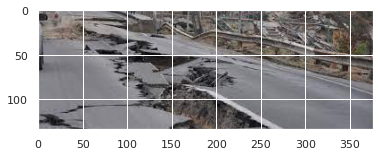



Class: Floods


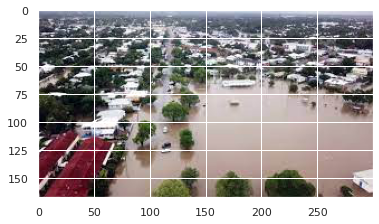



Class: Landslide


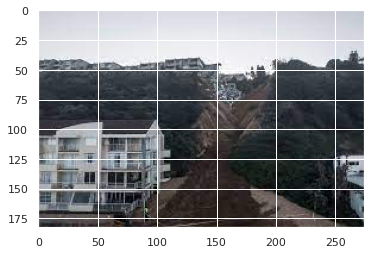

In [ ]:
#plotting training image of each individual classs

for i in classes:
    print('Class:', i)
    path = os.path.join(train_path, i)
    
    for img in os.listdir(path):
        img_array = mpimg.imread(os.path.join(path, img))
        plt.imshow(img_array)
        plt.show()
        print('\n')
        break


AS we can see that images are of non-uniform dimensions. So we will set target size for all images

In [ ]:
image_size = (300, 300)
batch_size = 4

In [ ]:
image_size[0]

200

In [ ]:
#create training data

train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size = image_size,
                                                   class_mode = 'categorical',
                                                    batch_size= batch_size)

Found 13 images belonging to 3 classes.


In [ ]:
#create testing data
#for testing data we will provide directory as img_path instead os test_path because test_path has no subdirectories only list of images
#and classes = ['test'] so that it will generate from test folder only

test_datagen = ImageDataGenerator(rescale = 1.0/255)

test_generator = test_datagen.flow_from_directory(base_path,
                                                   target_size = image_size,
                                                   classes = ['Test'],
                                                   batch_size= batch_size)

Found 7 images belonging to 1 classes.


In [ ]:
# Initialize the base model.
# Set the input shape and remove the dense layers.
vgg = VGG16(input_shape = (image_size[0], image_size[1], 3), include_top = False, weights = 'imagenet' )

#we don't need to train weights again
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
#build our customised model

x = layers.Flatten()(vgg.output)
output = layers.Dense(units = 3, activation = 'softmax')(x)

model = Model(inputs = vgg.input, outputs = output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0   

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#adding callback condition
cb = EarlyStopping(monitor = 'accuracy', patience = 3, min_delta = 0.01, verbose = 1)

In [ ]:
hist = model.fit(train_generator, epochs = 100, callbacks = [cb])

Epoch 1/100
4/4 [==============================] - 0s 89ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 2/100
4/4 [==============================] - 0s 81ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 105ms/step - loss: 4.3202e-04 - accuracy: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 103ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 4: early stopping


In [ ]:
#finding out indices for every class
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Earthquake', 1: 'Floods', 2: 'Landslide'}

In [ ]:
pred = model.predict(test_generator)
pred

2/2 [==============================] - 0s 82ms/step


array([[6.8867911e-04, 2.1813596e-06, 9.9930918e-01],
       [5.8498442e-01, 6.5703978e-05, 4.1494989e-01],
       [1.5659718e-05, 5.2991031e-06, 9.9997902e-01],
       [7.3805791e-06, 1.9743111e-05, 9.9997282e-01],
       [1.4987592e-01, 6.2450847e-05, 8.5006166e-01],
       [3.2452260e-06, 9.1189045e-01, 8.8106282e-02],
       [2.4578819e-02, 2.4651823e-07, 9.7542089e-01]], dtype=float32)

In [ ]:
pred_indices = np.argmax(pred, axis = 1)
pred_indices

array([2, 0, 2, 2, 2, 1, 2])

In [ ]:
#creating a function that will take an image path & will classify it 

def predict_image(path):

  #perform some operations on the image before feeding it to the model
  img = load_img(path, target_size = image_size)
  img_array = img_to_array(img)
  img_array = img_array/255.0
  img_array = np.expand_dims(img_array, axis = 0)

  #predicting the label
  classes = model.predict([img_array])
  class_index = np.argmax(classes, axis = 1)[0]
  class_name = labels[class_index]
  
  #displaying the image
  im = mpimg.imread(path)
  plt.imshow(im)
  print(class_name)


1/1 [==============================] - 0s 19ms/step


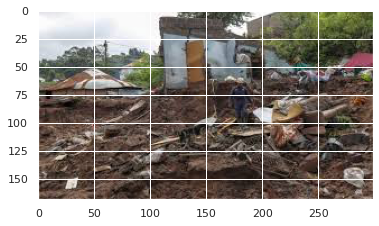

In [ ]:
predict_image('/content/drive/MyDrive/Train_Test/Test/2.jpeg')

1/1 [==============================] - 0s 16ms/step
Landslide


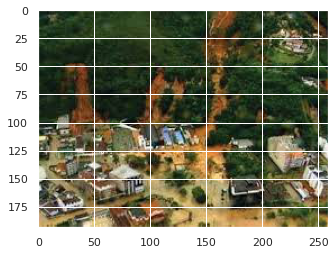

In [ ]:
predict_image('/content/drive/MyDrive/Train_Test/Test/3.jpeg')

1/1 [==============================] - 0s 18ms/step
Landslide


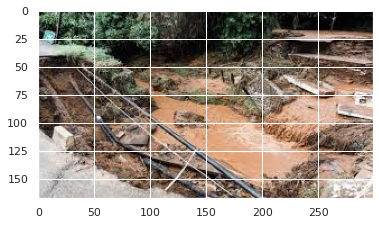

In [ ]:
predict_image('/content/drive/MyDrive/Train_Test/Test/7.jpeg')

1/1 [==============================] - 0s 17ms/step
Floods


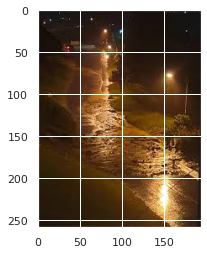

In [ ]:
predict_image('/content/drive/MyDrive/Train_Test/Test/test1.jpeg')